In [257]:
import pickle
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import json
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np
import scipy.sparse as sparse
from sklearn.decomposition import TruncatedSVD

# GENERAL ANALYSIS AND PLOTS

In [258]:
per_word_data = pd.read_pickle('files/per_word_data.pkl') 
filtered_per_word_data = pd.read_pickle('files/filtered_per_word_data.pkl')
#filtered_per_word_data

In [259]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

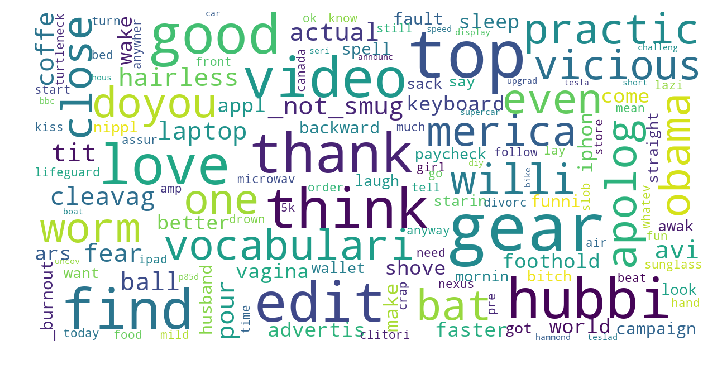

In [274]:
#This tells total word count per each day per each user
#per_word_data.groupby(['id', 'counter']).size().reset_index(name='counts').head(10)
#per_word_data.groupby(['counter', 'text']).count()
#per_word_data.groupby(['counter', 'text']).filter(lambda group: group.size > X).count()


filtered_per_word_data.loc[(filtered_per_word_data['counter'] <=7) & (filtered_per_word_data['target']==1.0)].groupby(['text']).size().sort_values(ascending=False)
filtered_per_word_data.loc[(filtered_per_word_data['counter'] <=7) & (filtered_per_word_data['target']==0.0)].groupby(['text']).size().sort_values(ascending=False)

show_wordcloud(' '.join(filtered_per_word_data.loc[(filtered_per_word_data['counter'] <=7) & (filtered_per_word_data['target']==1.0)].text))
#show_wordcloud(' '.join(filtered_per_word_data.loc[(filtered_per_word_data['counter'] <=7) & (filtered_per_word_data['bi_target']==1)].text))
#show_wordcloud(' '.join(filtered_per_word_data.loc[(filtered_per_word_data['counter'] <=7) & (filtered_per_word_data['target']==0.0)].text))


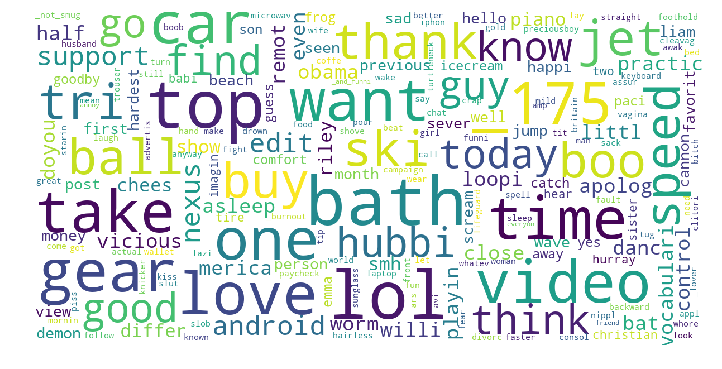

In [281]:
show_wordcloud(' '.join(filtered_per_word_data.loc[(filtered_per_word_data['counter'] <=30) & (filtered_per_word_data['target']==1.0)].text))


In [262]:
#show_wordcloud(' '.join(filtered_per_word_data.loc[(filtered_per_word_data['counter'] <=60) & (filtered_per_word_data['target']==0.0)].text))


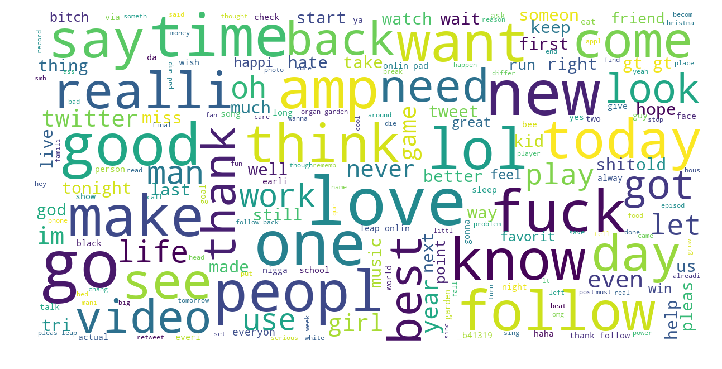

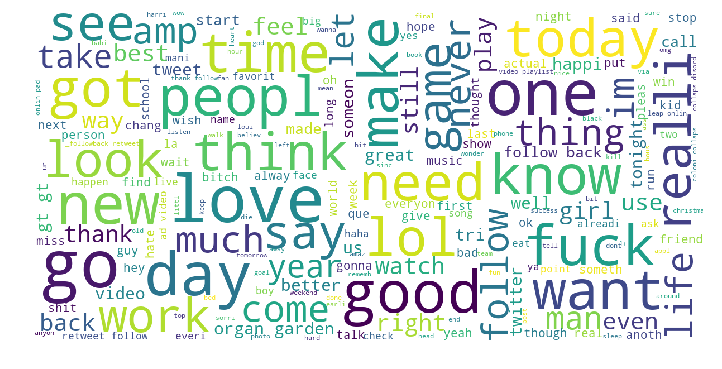

text
like      330
garden    256
get       247
not       242
follow    223
dtype: int64

In [265]:
filtered_per_word_data = pd.read_pickle('files/filtered_per_word_data.pkl')
#total words count for last 7 days
filtered_per_word_data.loc[(filtered_per_word_data['counter'] <=7)].groupby(['counter','sentiment']).size()

#last 7 seven days word cloud
show_wordcloud(' '.join(filtered_per_word_data.loc[(filtered_per_word_data['counter'] <=7)].text))

#last 30  days word cloud
show_wordcloud(' '.join(filtered_per_word_data.loc[(filtered_per_word_data['counter'] <=30)].text))
per_word_data.loc[(per_word_data['counter'] <=30)].groupby(['text']).size().sort_values(ascending=False).head()
#.value_counts(normalize=True)

# Sentiments

In [266]:
def plot_sentiment_data(word_data, no_of_days,col_name, label):
    group_sentiment = word_data.loc[(word_data['counter'] <=no_of_days) & (word_data[col_name]==label)].groupby(['counter','sentiment']).size().unstack(fill_value=0).stack().reset_index() #.size().sort_values(ascending=False)
    
    group_sentiment = group_sentiment.rename(columns= {0: 'count'})

    groupcount = group_sentiment.groupby('counter')['count'].sum().reset_index()

    ws = pd.merge(group_sentiment, groupcount, on=['counter'],  how='inner')
    ws['senti_percent'] = ws['count_x'] / ws['count_y']
    
    negative_percet = ws[ws['sentiment']=='negative']['senti_percent'].tolist()
    positive_percet = ws[ws['sentiment']=='positive']['senti_percent'].tolist()
    neutral_percet = ws[ws['sentiment']=='neutral']['senti_percent'].tolist()
    
    return negative_percet,positive_percet,neutral_percet

In [267]:
def sentiment_plot(negative_senti,neutral_senti,positive_senti, group):
    # create plot
    fig, ax = plt.subplots()
    index = np.arange(len(negative_percet))
    bar_width = 0.2
    opacity = 0.8
    
    rects1 = plt.bar(index, positive_percet, bar_width,
                 alpha=opacity,
                 color='lightseagreen',
                 label='Positive')
 
    rects2 = plt.bar(index + bar_width, neutral_percet, bar_width,
                 alpha=opacity,
                 color='plum',
                 label='Neutral')

    rects3 = plt.bar(index + bar_width+ bar_width, negative_percet, bar_width,
                alpha=opacity,
                 color='tomato',
                 label='Negative')


    plt.gcf().set_size_inches(10, 6)

    plt.xlabel('days')
    plt.ylabel('Sentiment')

    plt.title(group+": "+'Last'+" "+str(len(negative_percet))+" "+'days before the suicide')


    plt.xticks(index + bar_width, index+1)
    plt.legend()
    plt.legend(["Positive","Neutral","Negative"], loc = 'best')

    plt.tight_layout()
    plt.show()

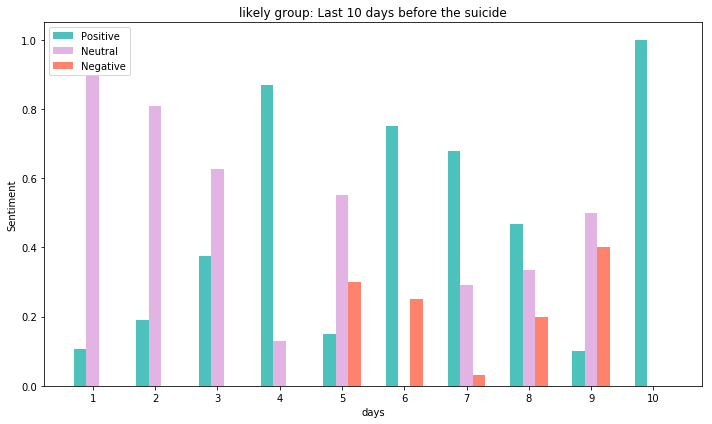

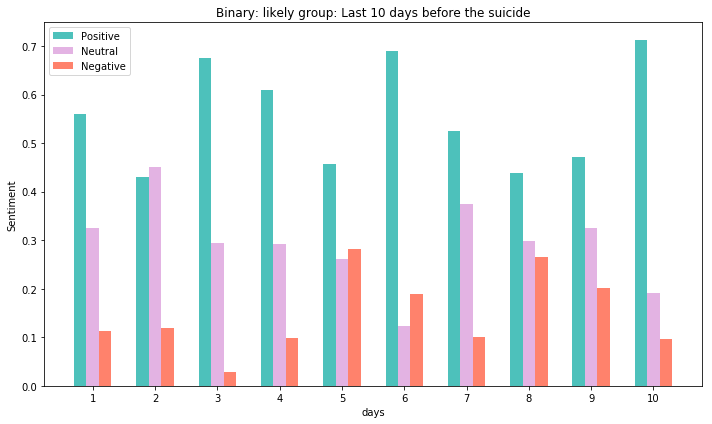

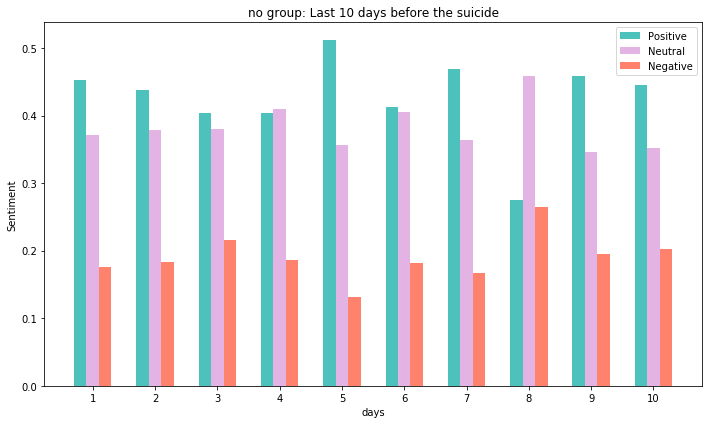

In [268]:
negative_percet,positive_percet,neutral_percet = plot_sentiment_data(filtered_per_word_data, 10, 'target', 1.0)
#print(negative_percet,neutral_percet, positive_percet)
sentiment_plot(negative_percet,positive_percet,neutral_percet, "likely group")

negative_percet,positive_percet,neutral_percet = plot_sentiment_data(filtered_per_word_data, 10, 'bi_target', 1)
#print(negative_percet,neutral_percet, positive_percet)
sentiment_plot(negative_percet,positive_percet,neutral_percet, "Binary: likely group")


negative_percet,positive_percet,neutral_percet = plot_sentiment_data(filtered_per_word_data, 10, 'target', 0.0)
#print(negative_percet,neutral_percet, positive_percet)
sentiment_plot(negative_percet,positive_percet,neutral_percet, "no group")


Sentiment is calculated per tweet. So, in this per-word data, the same word can have different sentiment attached with it depending on how it was used in the sentence. So let's see.

In [269]:
df = filtered_per_word_data.loc[(filtered_per_word_data['counter'] <=60)].groupby(['text','sentiment']).size().sort_values(ascending=False).reset_index()

#print(df.to_string())
#filtered_per_word_data.loc[(filtered_per_word_data['counter'] <=7) & (filtered_per_word_data['target']==1.0)].groupby(['text']).size().sort_values(ascending=False)


In [270]:
# from collections import Counter

# counts = Counter(df.text)
# print(counts)

# for key in counts:
#     if counts[key] > 2:
#         print(key)
#print(key for key in counts if counts[key] > 2)
#df[df.text.isin([key for key in counts if counts[key] > 2])]

#df.text.value_counts().reset_index(name="count").query("count > 1")

In [271]:
#((df.text.value_counts()>2)==True)

#df.text.value_counts().reset_index(name="count").query("count > 1")

# Statistical Learning

In [272]:
tweet_data = pd.read_pickle('files/tweet_data.pkl')
#tweet_data['text'] = tweet_data['text'].apply(_stemmerAndStop)

In [273]:
#transforming column data to fit with the model. 

tweet_data['retweet_count'].fillna(0, inplace=True) #replacing Nan with 0
tweet_data['retweet_count'] = tweet_data['retweet_count'].replace(['100+'], 100).astype('int') #typecasting retweet as int
#tweet_data['sentiment'] = tweet_data['sentiment'].replace(['positive', 'negative', 'neutral'], [1,0,2]).astype('category') #mapping string value integers
tweet_data['dayofweek'] = tweet_data['dayofweek'].astype('category').astype('category') 

#tweet_data
#tweet_data.isnull().sum()
#tweet_data['retweet_count'].fillna(0, inplace=True)
#tweet_data['retweet_count']

In [220]:
#tweet_data

In [221]:
dataset=tweet_data[['text','bi_target']]  #using binary class for model building 

In [222]:
# TF-IDF
#(21858, 21724)
#(21858, 21338) -- without stemming

# Extracting features from text files using frequency count vectorizer tfidf

count_vect = CountVectorizer()
counts = count_vect.fit_transform(dataset['text'])

tfidf_transformer = TfidfTransformer()
data_tfidf = tfidf_transformer.fit_transform(counts)
data_tfidf.shape

(21858, 17195)

In [212]:
#np.histogram(counts.toarray(), bins=10) #[0, 1, 2, 3])

Appending extra columns to the tweet text sparse matrix.

In [162]:
updated_data = sparse.hstack((data_tfidf,np.array(tweet_data['dayofweek'])[:,None]))
updated_data=sparse.hstack((updated_data,np.array(tweet_data['sentiment'])[:,None]))
updated_data=sparse.hstack((updated_data,np.array(tweet_data['retweet_count'])[:,None]))

In [226]:
X_train, X_test, y_train, y_test = train_test_split(
updated_data, dataset['bi_target'], test_size=0.2, random_state=42)

In [227]:
# Performance of NB Classifier

# Machine Learning
# Training Naive Bayes (NB) classifier on training data.
clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)
print("test score:",np.mean(predicted == y_test))

precision = sum(np.multiply(predicted,y_test))/sum(y_test)
print("precision:",precision)

recall = sum(np.multiply(predicted,y_test))/sum(predicted) 
print("recall:",recall)
    
f1_score = 2*(precision)*(recall)/(precision+recall)
print("f1score:",f1_score)

test score: 0.946477584629
precision: 0.0128205128205
recall: 0.5
f1score: 0.025


Feature selection by applying PCA to singular value decomposed sparse matrix.
#singular-value decomposition (SVD) is a factorization of a real or complex matrix. 

In [216]:
singular_value_decomposition = TruncatedSVD(2000)
Xpca = singular_value_decomposition.fit_transform(updated_data)
print("Before:",updated_data.shape)
print("After:", Xpca.shape)

Before: (21858, 17198)
After: (21858, 2000)


splitting data into training and test set

In [228]:
X_train, X_test, y_train, y_test = train_test_split(
Xpca, dataset['bi_target'], test_size=0.2, random_state=42)

In [193]:
print(X_train.shape, Xpca.shape)

(17486, 2000) (21858, 2000)


# Training Support Vector Machines - SVM and calculating its performance


In [194]:

# text_clf_svm = Pipeline([#('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
#                          ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=100,
#                                                     class_weight={1: 10},
#                                                    random_state=42))])
clf = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=100,
                                                    class_weight={1: 13},
                                                   random_state=42)

print("crossval score:",np.mean(cross_val_score(clf,X_train, y_train, cv=10)))

clf.fit(X_train, y_train)
predicted_svm = clf.predict(X_test)
print("test score:",np.mean(predicted_svm == y_test))

precision = sum(np.multiply(predicted_svm,y_test))/sum(y_test)
print("precision:",precision)

recall = sum(np.multiply(predicted_svm,y_test))/sum(predicted_svm) 
print("recall:",recall)

f1_score = 2*(precision)*(recall)/(precision+recall)
print("f1score:",f1_score)

crossval score: 0.928512697023
test score: 0.954483074108
precision: 0.461538461538
recall: 0.596685082873
f1score: 0.520481927711


In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.98  0.02]
 [ 0.54  0.46]]


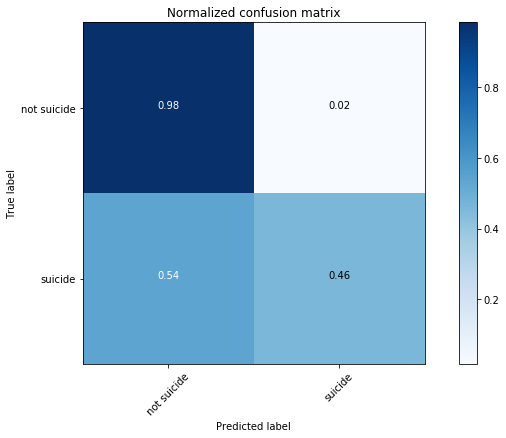

In [195]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, predicted_svm)
np.set_printoptions(precision=2)
plt.figure()
plt.gcf().set_size_inches(10, 6)
plot_confusion_matrix(cnf_matrix, classes=['not suicide','suicide'], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

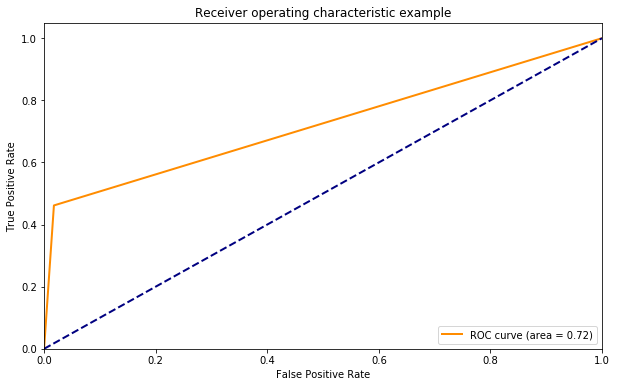

In [197]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(y_test, predicted_svm)
    roc_auc[i] = auc(fpr[i], tpr[i])

#print(roc_auc_score(y_test, predicted_svm))


plt.figure()
plt.gcf().set_size_inches(10, 6)
lw = 2
# plt.plot(fpr[0], tpr[0], color='cyan',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0]) 
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0]) #suicide class
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# setting up hyperparameters

In [192]:
#14.1 seems to be
fscores = []
weights = []

crossval_list = []
 
for weight in np.arange(12.0, 14.0, 0.2):
    text_clf_svm = Pipeline([#('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                             ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=100,
                                                        class_weight={1: weight},
                                                       random_state=42))])
    
    crossval = np.mean(cross_val_score(text_clf_svm, X_train, y_train, cv=10))
    #crossval_list.append(crossval)
    
    print("weight:",weight)
    print("crossval score:",crossval)
    
    text_clf_svm.fit(X_train, y_train)
    predicted_svm = text_clf_svm.predict(X_test)
    print("test score:",np.mean(predicted_svm == y_test))

    precision = sum(np.multiply(predicted_svm,y_test))/sum(y_test)
    print("precision:",precision)

    recall = sum(np.multiply(predicted_svm,y_test))/sum(predicted_svm) 
    print("recall:",recall)
    
    f1_score = 2*(precision)*(recall)/(precision+recall)
    print("f1score:",f1_score)
    #fscores[weight] = f1_score
    #weights[weight] = weight
    fscores.append(f1_score)
    weights.append(weight)
    

weight: 12.0
crossval score: 0.933144896135
test score: 0.93526989936
precision: 0.465811965812
recall: 0.408239700375
f1score: 0.435129740519
weight: 12.2
crossval score: 0.931371833267
test score: 0.934126258005
precision: 0.465811965812
recall: 0.400735294118
f1score: 0.430830039526
weight: 12.4
crossval score: 0.932516554082
test score: 0.934126258005
precision: 0.470085470085
recall: 0.401459854015
f1score: 0.433070866142
weight: 12.6
crossval score: 0.929656338437
test score: 0.933668801464
precision: 0.474358974359
recall: 0.39928057554
f1score: 0.43359375
weight: 12.8
crossval score: 0.928512664314
test score: 0.93252516011
precision: 0.482905982906
recall: 0.393728222997
f1score: 0.433781190019
weight: 13.0
crossval score: 0.928512697023
test score: 0.954483074108
precision: 0.461538461538
recall: 0.596685082873
f1score: 0.520481927711
weight: 13.2
crossval score: 0.927311749244
test score: 0.931838975297
precision: 0.491452991453
recall: 0.391156462585
f1score: 0.435606060606

[0.43307086614173229, 0.43359374999999994, 0.43378119001919385, 0.52048192771084345, 0.43560606060606066, 0.43233082706766918, 0.43122676579925656, 0.43992606284658042]
[12.399999999999999, 12.599999999999998, 12.799999999999997, 12.999999999999996, 13.199999999999996, 13.399999999999995, 13.599999999999994, 13.799999999999994]


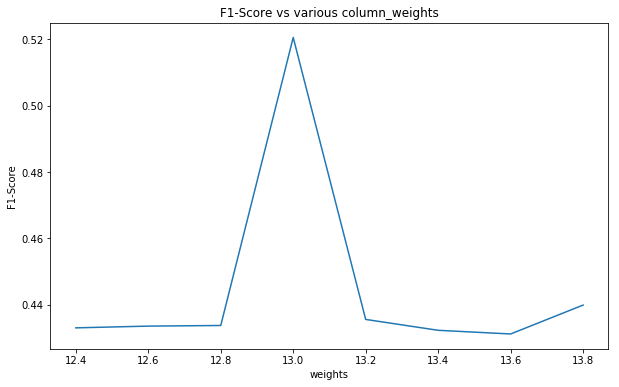

In [277]:
print(fscores[2:])
print(weights[2:])
plt.figure()
lw = 2
# plt.plot(fpr[0], tpr[0], color='cyan',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0]) 
plt.gcf().set_size_inches(10, 6)
plt.plot(weights[2:], fscores[2:])
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.ylim([0.0, 1.05])
plt.xlabel('weights')
plt.ylabel('F1-Score')
plt.title('F1-Score vs various column_weights')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#14.1 seems to be

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                           random_state=0, shuffle=False)
# clf = RandomForestClassifier(max_depth=2, random_state=0)


# RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=2, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
#             oob_score=False, random_state=0, verbose=0, warm_start=False)

fscores = []
weights = []


class_weight_list = [
                     {1: 14},
                     {1: 14.1},
                     {1: 14.2},
                     {1: 14.3},
                     {1: 14.4},
                     {1: 14.5},
                     {1: 14.6},
                     {1: 14.7},
                     {1: 14.8},
                     {1: 14.9},
                     {1: 15},
                    
                    ]
crossval_list = []
for weight in range(20):
    text_clf_rf = Pipeline([#('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                             ('clf-rf', RandomForestClassifier(max_depth=2, random_state=0
                                                              , class_weight=None))])
    
    text_clf_rf.fit(X_train, y_train)
    
    crossval = np.mean(cross_val_score(text_clf_rf, X_train, y_train, cv=10))
    #crossval_list.append(crossval)
    
    print("weight:",weight)
    print("crossval score:",crossval)
    
    text_clf_rf.fit(X_train, y_train)
    predicted_svm = text_clf_rf.predict(X_test)
    print("test score:",np.mean(predicted_svm == y_test))

    precision = sum(np.multiply(predicted_svm,y_test))/sum(y_test)
    print("precision:",precision)

    recall = sum(np.multiply(predicted_svm,y_test))/sum(predicted_svm) 
    print("recall:",recall)
    
    f1_score = 2*(precision)*(recall)/(precision+recall)
    print("f1score:",f1_score)
    #fscores[weight] = f1_score
    #weights[weight] = weight
    fscores.append(f1_score)
    weights.append(weight)


# NETWORK ANALYSIS

The network graph consists of twitter ids as nodes and follower connection as edge. A->B would mean A follows B. Right now I have all A's in the data which means I have the twitter IDs but I do not have the information about who follows who. In order to collect that information, I have written an script that uses tweepy library and Twitter API to fetch the follower information against each twitter ID. 

In [229]:
import networkx as nx
import matplotlib.pyplot as plt
import random
plt.rcParams["figure.figsize"] = (10,10)

Let's make edgelist out of the dictionary to feed into network libarary

In [230]:
def get_subset_nodes(follower_dict, num):
    #len(follower_list_maybe.keys())
    randomkey_list = set()
    while len(randomkey_list) < num:  #in range(10):
        randomkey_list.add(int(random.choice(list(follower_dict))))
    return randomkey_list

In [231]:
def convert_dict_to_edgelist(user2friend):
    node_set = set()
    edge_list = []
    for userid, friends in user2friend.items():
        node_set.add(userid)
        for friend in friends:
            node_set.add(friend)
            tup = (int(userid), friend)
            edge_list.append(tup)
    return node_set, edge_list

In [232]:
def get_layout(graph):
    df = pd.DataFrame(index=graph.nodes(), columns=graph.nodes())
    for row, data in nx.shortest_path_length(graph):
        for col, dist in data.items():
            df.loc[row,col] = dist

    df = df.fillna(df.max().max())

    layout = nx.kamada_kawai_layout(graph, dist=df.to_dict())
    return layout

In [233]:
def visualize_network(graph, selected_nodes,layout, image_name):
    colors = []
    node_sizes = []
    edge_color = []
    cmap = plt.get_cmap('Greens')
    
    
    for node in graph:
        if node in selected_nodes:
            colors.append('red')
            node_sizes.append(50)
        else:
            #rgba = cmap(dict_1[node])
            colors.append('yellow')
            node_sizes.append(20)
    
    # drawing nodes and edges separately so we can capture collection for colobar
    #pos = nx.spring_layout(G)
    pos = nx.spring_layout(graph,k=0.2,iterations=10)
    ec = nx.draw_networkx_edges(graph, layout, alpha=0.2 )
    nc = nx.draw_networkx_nodes(graph, layout, node_color=colors , #nodelist=nodes, 
                            with_labels=False, node_size= node_sizes) #cmap=plt.cm.jet)


    #plt.colorbar(nc)
    plt.axis('off')
    plt.savefig(image_name)
    plt.show()
    
    
    # # drawing nodes and edges separately so we can capture collection for colobar
    # #pos = nx.spring_layout(G)
    # pos = nx.spring_layout(G,k=0.2,iterations=10)
    # ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
    # nc = nx.draw_networkx_nodes(G, pos, node_color=colors,  #nodelist=nodes, 
    #                             with_labels=False, node_size= node_sizes) #cmap=plt.cm.jet)


    # #plt.colorbar(nc)
    # plt.axis('off')

    # plt.show()

# YES CLASS

In [234]:
pkl_file_likely = open('files/likely_follower_count.pkl', 'rb')
follower_list_likely = pickle.load(pkl_file_likely)
pkl_file_likely.close()

In [237]:
node_set, edge_list = convert_dict_to_edgelist(follower_list_likely)

In [238]:
G = nx.DiGraph(tag="Likely")
G.add_edges_from(edge_list)
print(nx.info(G))
density = nx.density(G)
print("Network density:", density) #This is simply the ratio of actual edges in the network to all possible edges in the network

Name: 
Type: DiGraph
Number of nodes: 304
Number of edges: 301
Average in degree:   0.9901
Average out degree:   0.9901
Network density: 0.003267760986624978


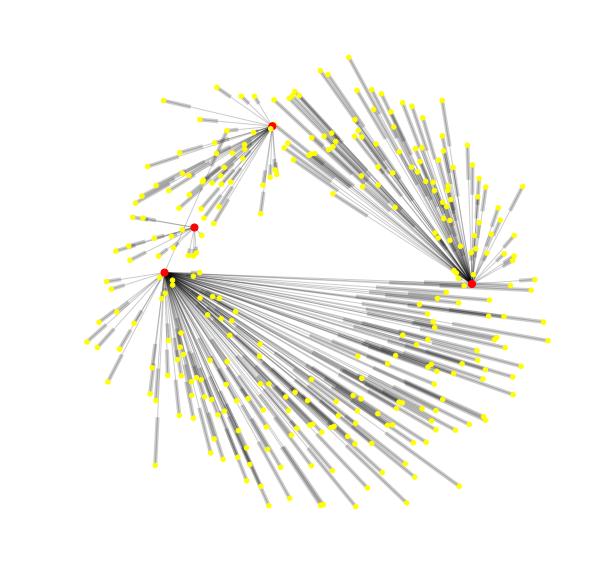

In [239]:
likely_nodes = list(follower_list_likely.keys())
layout= get_layout(G)
visualize_network(G, likely_nodes,layout,"files/likely_network.png")

# NO

In [240]:
no_file_a = open('files/no_follower_count_2.pkl', 'rb')
follower_list_no = pickle.load(no_file_a)
no_file_a.close()

no_file_b = open('files/no_follower_count_3.pkl', 'rb')
#follower_list_no = pickle.load(no_file_b)
follower_list_no.update(pickle.load(no_file_b))
no_file_b.close()

no_file_c = open('files/no_follower_count_4.pkl', 'rb')
follower_list_no.update(pickle.load(no_file_c))
no_file_b.close()

#follower_list_maybe.update(follower_list_maybe_b)
#node_set, edge_list = convert_dict_to_edgelist(follower_list_maybe)

In [241]:
no_randomkey_list = get_subset_nodes(follower_list_no, 10)
subset_follower_list_no = dict(filter(lambda i:i[0] in list(no_randomkey_list), follower_list_no.items()))
node_set, edge_list = convert_dict_to_edgelist(subset_follower_list_no)

In [242]:
G_sub_no = nx.DiGraph(tag="subset_no")
G_sub_no.add_edges_from(edge_list)
print(nx.info(G_sub_no))
density = nx.density(G_sub_no)
print("Network density:", density)

Name: 
Type: DiGraph
Number of nodes: 723
Number of edges: 729
Average in degree:   1.0083
Average out degree:   1.0083
Network density: 0.00139653567200377


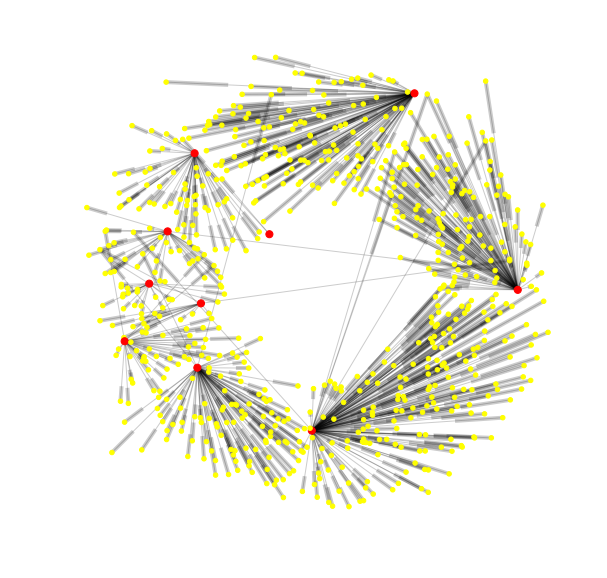

In [278]:
no_nodes = list(subset_follower_list_no.keys())
layout= get_layout(G_sub_no)
visualize_network(G_sub_no, no_nodes,layout,"files/no_network.png")

# MAYBE

In [246]:
# read followerlist dictionary for likely, maybe and no
follower_list_maybe = json.load(open('files/followers_maybe.txt'))
follower_list_maybe = {int(key):follower_list_maybe[key] for key in follower_list_maybe}
#follower_list_maybe = {int(k):int(v) for k,v in follower_list_maybe.items()}
pkl_file_a = open('files/maybe_follower_count_1.pkl', 'rb')
follower_list_maybe_b = pickle.load(pkl_file_a)
pkl_file_a.close()
follower_list_maybe.update(follower_list_maybe_b)
#node_set, edge_list = convert_dict_to_edgelist(follower_list_maybe)

In [247]:
maybe_randomkey_list = get_subset_nodes(follower_list_maybe, 10)
subset_follower_list_maybe = dict(filter(lambda i:i[0] in list(maybe_randomkey_list), follower_list_maybe.items()))
node_set, edge_list = convert_dict_to_edgelist(subset_follower_list_maybe)


In [248]:
G_sub_maybe = nx.DiGraph(tag="subset_may")
G_sub_maybe.add_edges_from(edge_list)
print(nx.info(G_sub_maybe))
density = nx.density(G_sub_maybe)
print("Network density:", density)

Name: 
Type: DiGraph
Number of nodes: 329
Number of edges: 326
Average in degree:   0.9909
Average out degree:   0.9909
Network density: 0.0030209800578248945


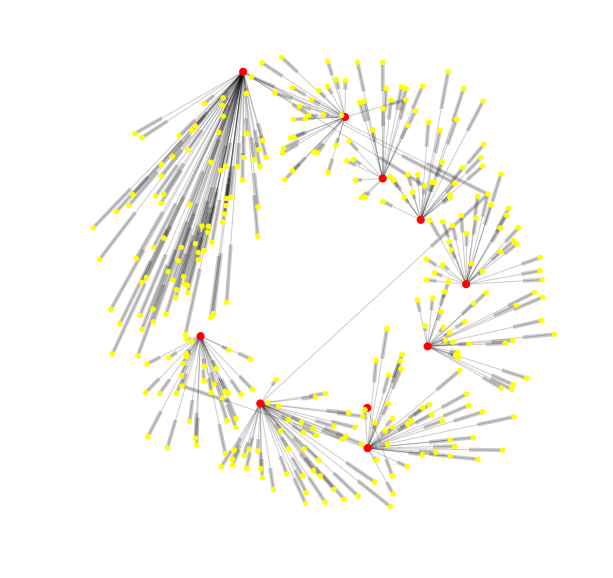

In [249]:
maybe_nodes = list(subset_follower_list_maybe.keys())
layout= get_layout(G_sub_maybe)
visualize_network(G_sub_maybe, maybe_nodes,layout, "files/maybe_network.png")

# ALL COMBINED

In [250]:
combined_network = {}
combined_network.update(follower_list_likely)
combined_network.update(subset_follower_list_maybe)
combined_network.update(subset_follower_list_no)
node_set, edge_list = convert_dict_to_edgelist(combined_network)

In [251]:
combined_net = nx.DiGraph(tag="complete")
combined_net.add_edges_from(edge_list)
print(nx.info(combined_net))
density = nx.density(combined_net)
print("Network density:", density)

Name: 
Type: DiGraph
Number of nodes: 1331
Number of edges: 1356
Average in degree:   1.0188
Average out degree:   1.0188
Network density: 0.0007660021579116838


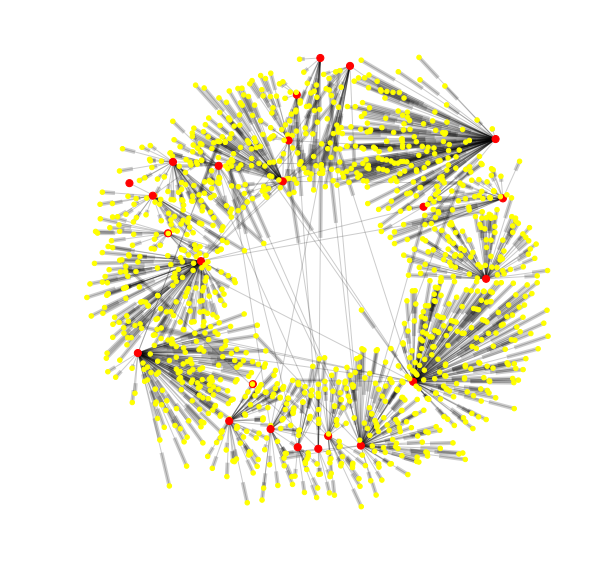

In [252]:
combined_nodes = list(combined_network.keys())
layout= get_layout(combined_net)
visualize_network(combined_net, combined_nodes,layout,"files/full_network.png")

In [253]:
#shortest_path = nx.shortest_path(G, source=1656303984, target=375923535)
#nx.diameter(G) #longest of all shortest path. This requires that all nodes in graph are connected which is not the case 
                #This simply means that your graph, as you already saw, has more than one component. Because there are some nodes that have no path at all to others,
                #it is impossible to find all of the shortest paths. 
        
#print(nx.is_connected(G))

print(nx.weakly_connected_components(G))

<generator object weakly_connected_components at 0x1a23fabf68>


In [254]:
import community #This is the python-louvain package we installed.

triadic_closure = nx.transitivity(G)
print("Triadic closure:", triadic_closure)
#communities = community.best_partition(G)

Triadic closure: 0


In [256]:
from operator import itemgetter

#print("indegree sorted",sorted(G.in_degree(),key=itemgetter(1),reverse=True))
#print("outdegree sorted",sorted(G.out_degree(),key=itemgetter(1),reverse=True))
#print("neighbor of 10228272:",G.in_edges(10228272))